In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)

---

###0. 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vgames2.csv to vgames2 (2).csv


In [ ]:
import io

df = pd.read_csv(io.StringIO(uploaded['vgames2.csv'].decode('utf-8')))   
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [ ]:
df.dtypes

Unnamed: 0       int64
Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

In [ ]:
def KM(string):
    data = (df[string].replace(r'[KM]+$', '', regex=True).astype(float) * 
            df[string].str.extract(r'[\d\.]+([KM]+)', expand=False)
              .fillna(1)
              .replace(['K','M'], [0.001, 1]).astype(float)) 
    return data

In [ ]:
df['NA_Sales'] = KM('NA_Sales')
df['EU_Sales'] = KM('EU_Sales')
df['JP_Sales'] = KM('JP_Sales')
df['Other_Sales'] = KM('Other_Sales')

---

###1. 지역에 따른 선호 게임 장르

 > 모든 연도에 대한 지역별, 장르별 출고량



In [ ]:
df_01 = df.melt(id_vars = 'Genre', value_vars = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

In [ ]:
df_01 = df_01.rename(
        columns = {
        'variable': 'Local_area', 
        'value': 'amount'
        }
)
df_01

,Genre,Local_area,amount
0,Action,NA_Sales,0.04
1,Action,NA_Sales,0.17
2,Adventure,NA_Sales,0.00
3,Misc,NA_Sales,0.04
4,Platform,NA_Sales,0.12
...,...,...,...
66387,Platform,Other_Sales,0.01
66388,Action,Other_Sales,0.00
66389,Sports,Other_Sales,0.13
66390,Action,Other_Sales,0.03


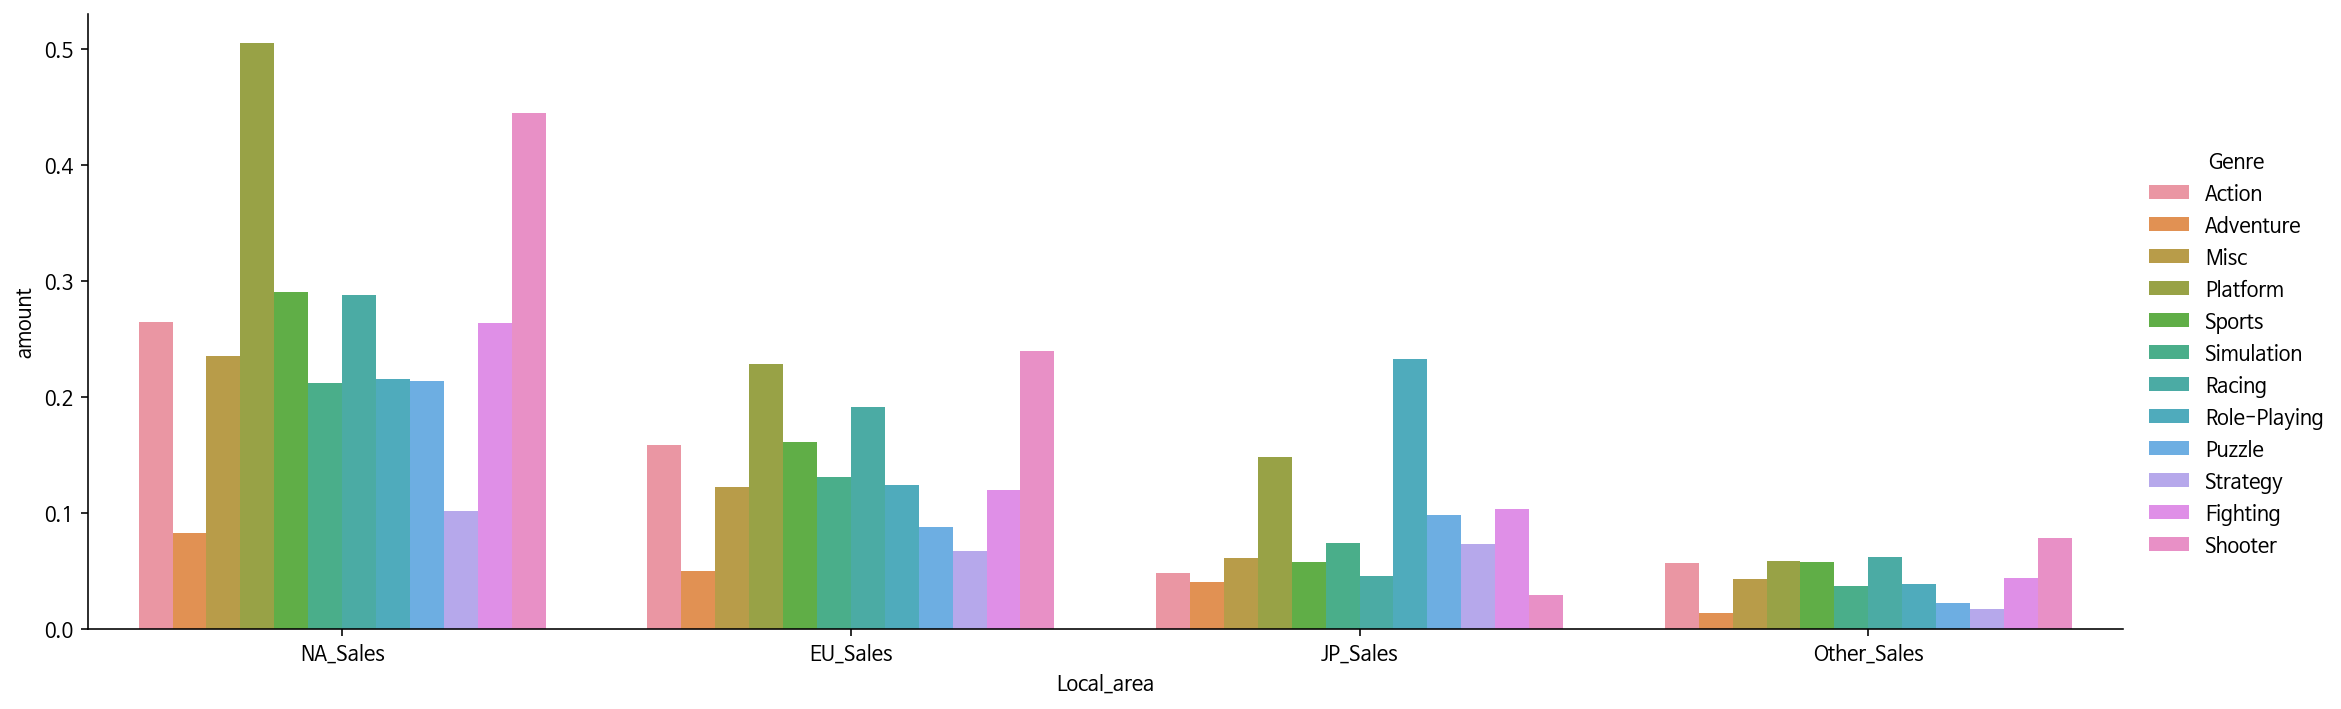

In [ ]:
sns.catplot(x = 'Local_area', y = 'amount', hue = 'Genre', kind = 'bar', ci=None, data = df_01, height = 5, aspect=3);

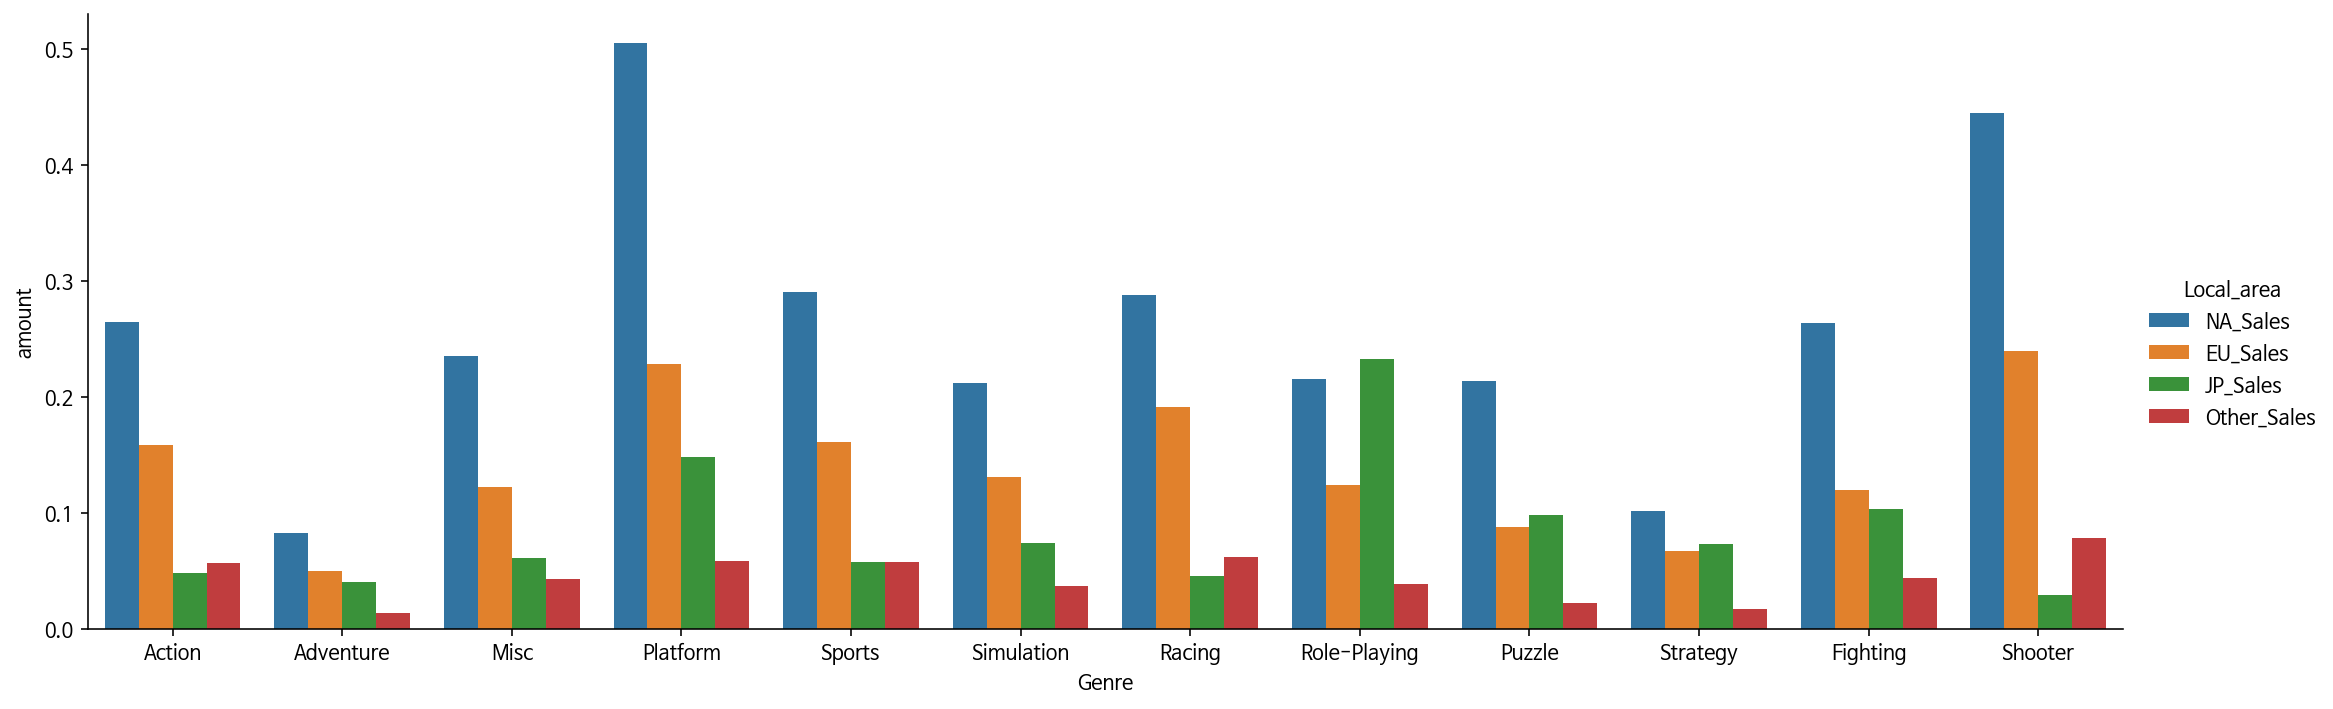

In [ ]:
sns.catplot(x = 'Genre', y = 'amount', hue = 'Local_area', kind = 'bar', ci=None, data = df_01, height = 5, aspect=3);

---

###2. 연도별 게임 트랜드
> 2010년 이후 게임 트랜드




In [ ]:
df_02 = df.melt(id_vars = ['Year', 'Genre'], value_vars = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])

In [ ]:
df_02 = df_02.dropna()

In [ ]:
def to_num(year):
    for i in range(99):
        if i <= 20:
            if year == i:
                year = 2000 + i
        else :
            if year == i:
                year = 1900 + i
    return int(year)

In [ ]:
df_02['Year'] = df_02['Year'].apply(to_num)
df_02

,Year,Genre,variable,value
0,2008,Action,NA_Sales,0.04
1,2009,Action,NA_Sales,0.17
2,2010,Adventure,NA_Sales,0.00
3,2010,Misc,NA_Sales,0.04
4,2010,Platform,NA_Sales,0.12
...,...,...,...,...
66387,2006,Platform,Other_Sales,0.01
66388,2005,Action,Other_Sales,0.00
66389,2015,Sports,Other_Sales,0.13
66390,2013,Action,Other_Sales,0.03


In [ ]:
for i in range(1980,2010): 
    df_02 = df_02[df_02['Year'] != i]
for i in range(2017,2021):
    df_02 = df_02[df_02['Year'] != i]

In [ ]:
df_021 = df_02[df_02['variable'] == 'NA_Sales']
df_022 = df_02[df_02['variable'] == 'EU_Sales']
df_023 = df_02[df_02['variable'] == 'JP_Sales']
df_024 = df_02[df_02['variable'] == 'Other_Sales']

In [ ]:
df_020 = df_02.drop(['variable'], axis=1)

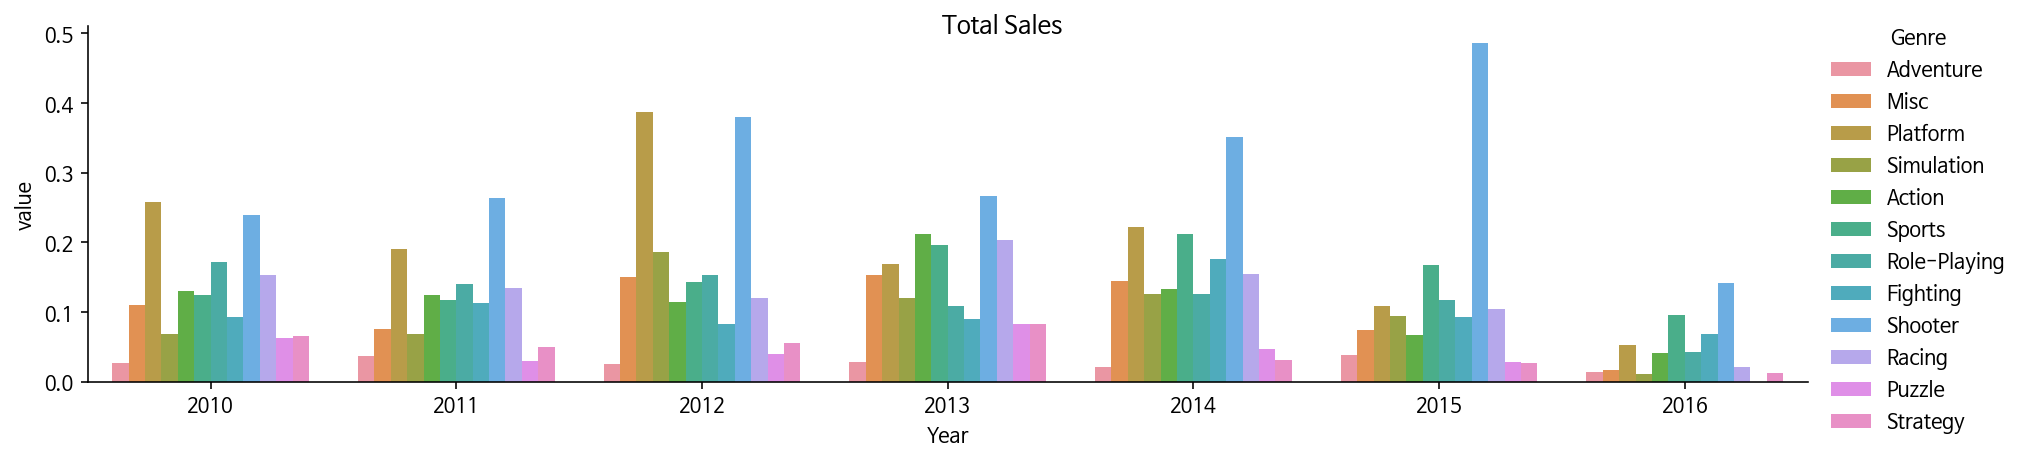

In [ ]:
df_020 = sns.catplot(x = 'Year', y = 'value', hue = 'Genre', kind = 'bar', ci=None, data = df_020, height = 3.2, aspect=4, legend=True)
df_020.fig.suptitle('Total Sales');

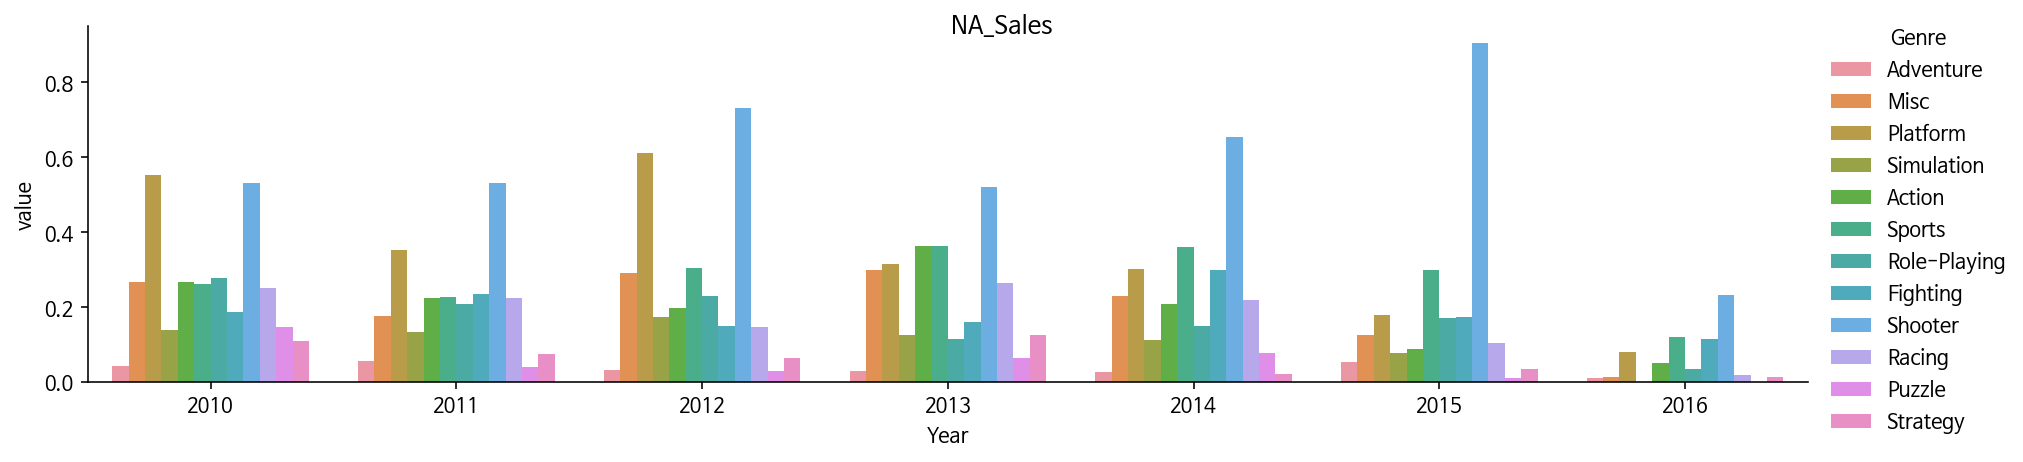

In [ ]:
df_021 = sns.catplot(x = 'Year', y = 'value', hue = 'Genre', kind = 'bar', ci=None, data = df_021, height = 3.2, aspect=4, legend=True)
df_021.fig.suptitle('NA_Sales');

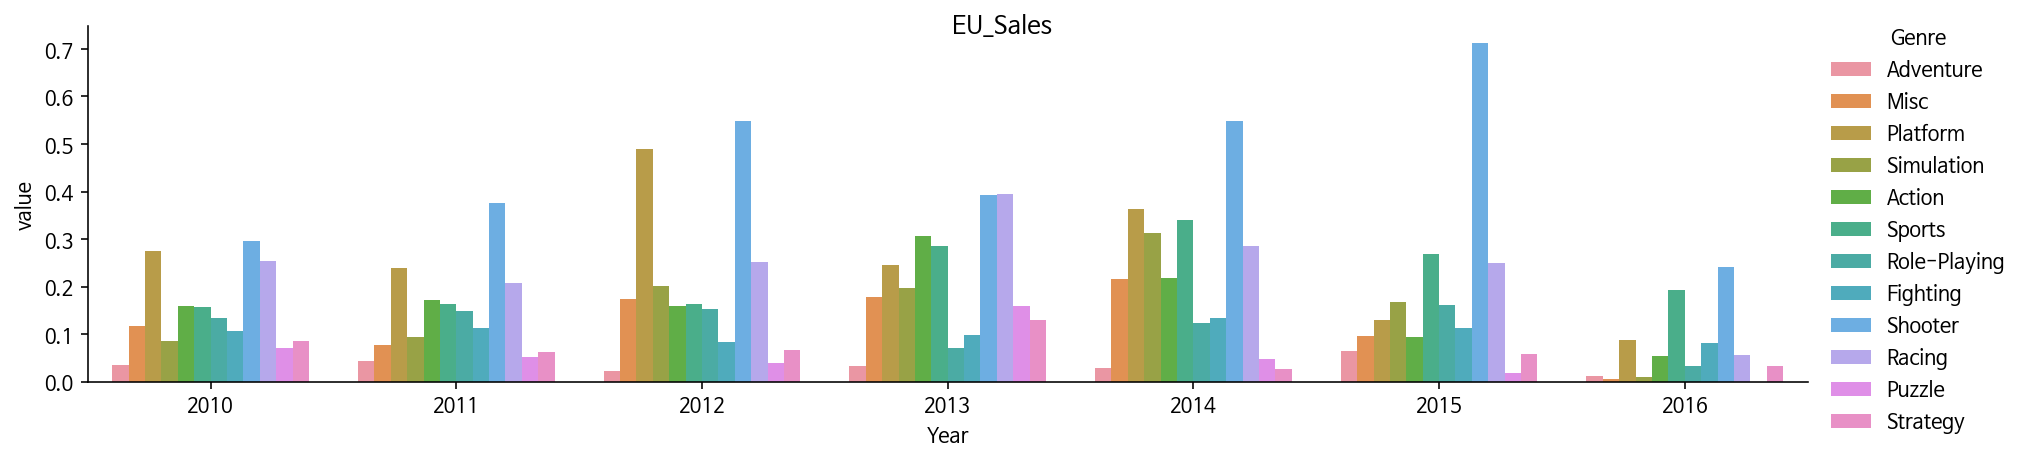

In [ ]:
df_022 = sns.catplot(x = 'Year', y = 'value', hue = 'Genre', kind = 'bar', ci=None, data = df_022, height = 3.2, aspect=4, legend=True)
df_022.fig.suptitle('EU_Sales');

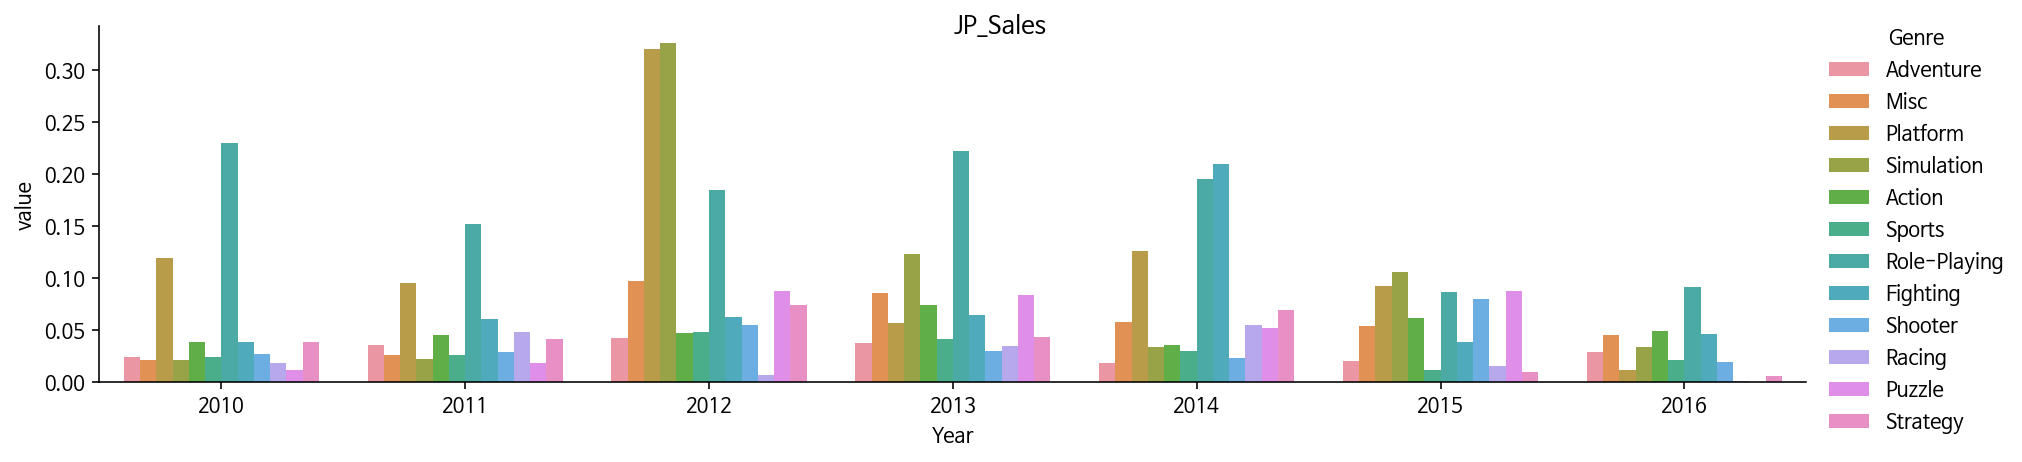

In [ ]:
df_023 = sns.catplot(x = 'Year', y = 'value', hue = 'Genre', kind = 'bar', ci=None, data = df_023, height = 3.2, aspect=4, legend=True)
df_023.fig.suptitle('JP_Sales');

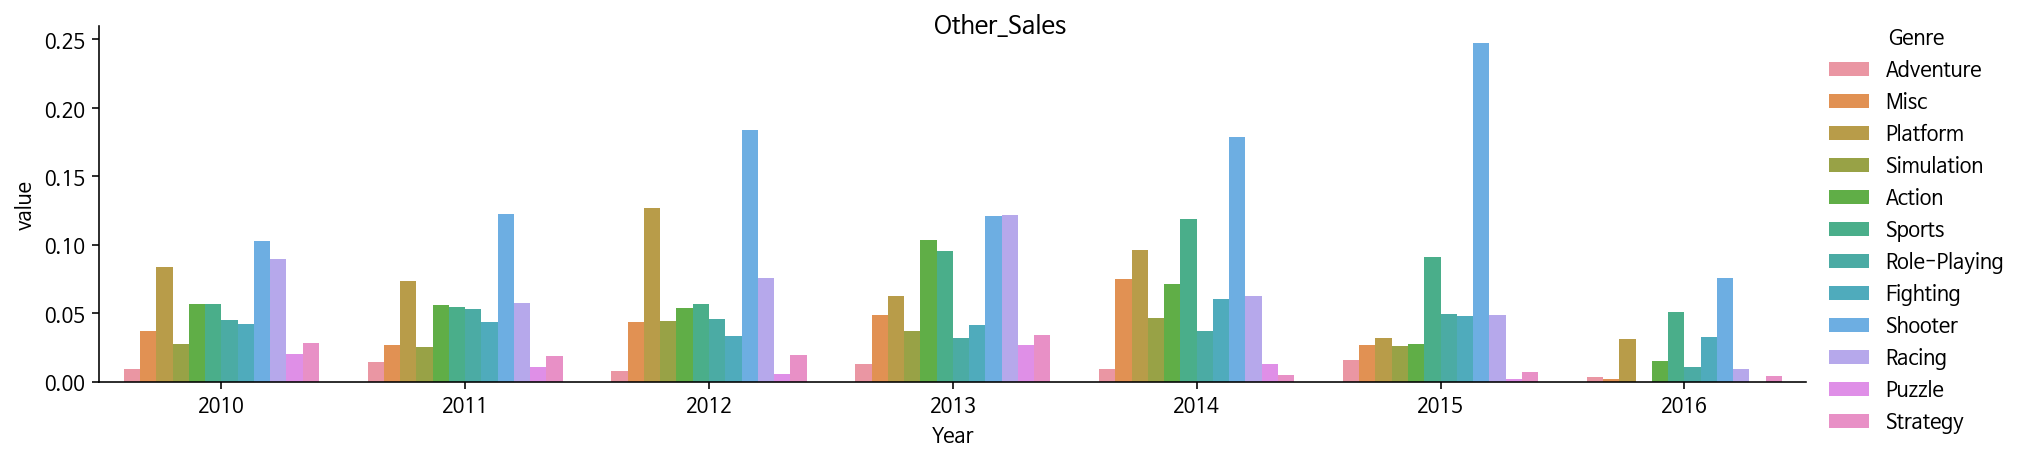

In [ ]:
df_024 = sns.catplot(x = 'Year', y = 'value', hue = 'Genre', kind = 'bar', ci=None, data = df_024, height = 3.2, aspect=4, legend=True)
df_024.fig.suptitle('Other_Sales');

---

###3. 출고량이 높은 게임에 대한 분석
 >  출고량 TOP XX 에 대한 Genre 선호도 분석

In [ ]:
df_03 = df

In [ ]:
df_03['Total_Sales'] = round(df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'], 2)
df_03 = df_03.fillna('-')

In [ ]:
def top10(portion,range,genre): 
    for i in range:
        globals()['df_03_top{}'.format(i)] = df_03.sort_values(by='Total_Sales', ascending=False).head(i)
        globals()['df_03_{}'.format(i)] = globals()['df_03_top{}'.format(i)][genre].value_counts()
        globals()['df_03_{}'.format(i)] = globals()['df_03_{}'.format(i)].reset_index()
        globals()['df_03_{}'.format(i)].loc[len(globals()['df_03_{}'.format(i)])] = globals()['df_03_{}'.format(i)].loc[globals()['df_03_{}'.format(i)][genre] < portion/100*len(globals()['df_03_top{}'.format(i)]),[genre]].sum(axis=0)
        globals()['df_03_{}'.format(i)] = globals()['df_03_{}'.format(i)].fillna('etc')
        globals()['df_03_{}'.format(i)] = globals()['df_03_{}'.format(i)][globals()['df_03_{}'.format(i)][genre] >= portion/100*len(globals()['df_03_top{}'.format(i)])]
        pie_chart(i,genre) 
    

In [ ]:
def pie_chart(i,genre):
    explode = [] 
    for x in range(len(globals()['df_03_{}'.format(i)])):
        explode.append(0.1)

    plt.rcParams["figure.figsize"] = (12, 8)
    plt.pie(globals()['df_03_{}'.format(i)][genre], labels =globals()['df_03_{}'.format(i)]['index'] , autopct='%.1f%%', counterclock=False, startangle=90, explode=explode,shadow=False)
    plt.title('TOP {}'.format(i), fontsize=20);
    plt.show()

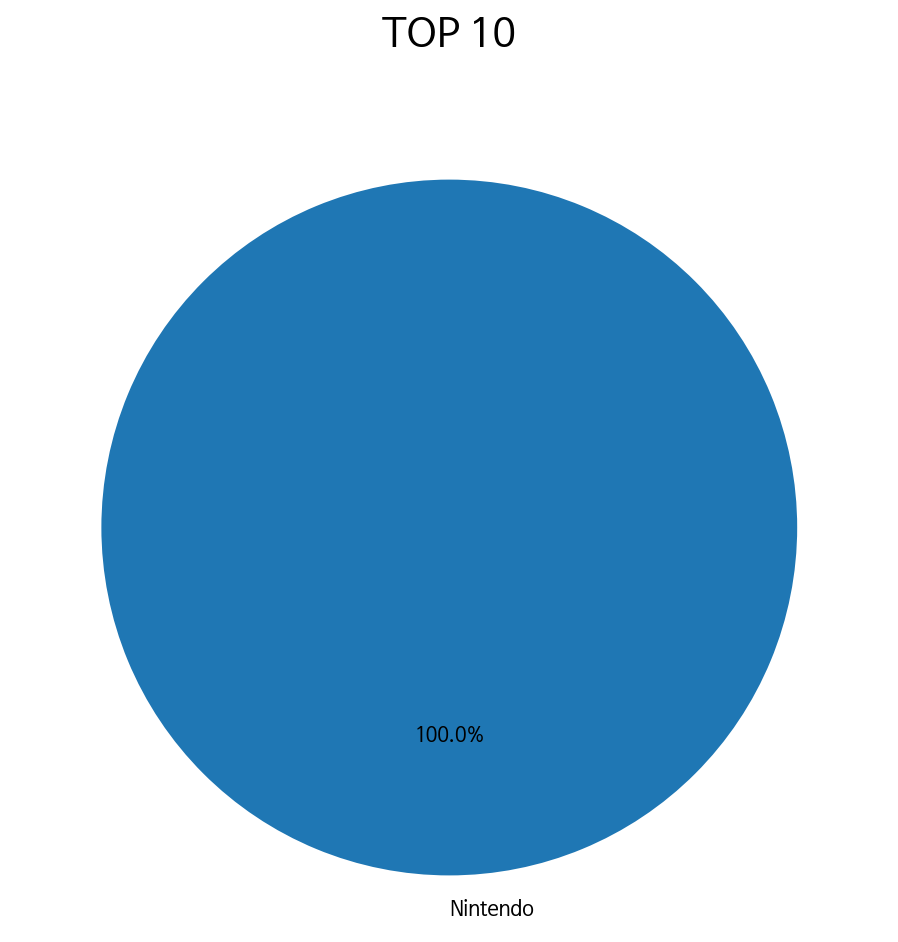

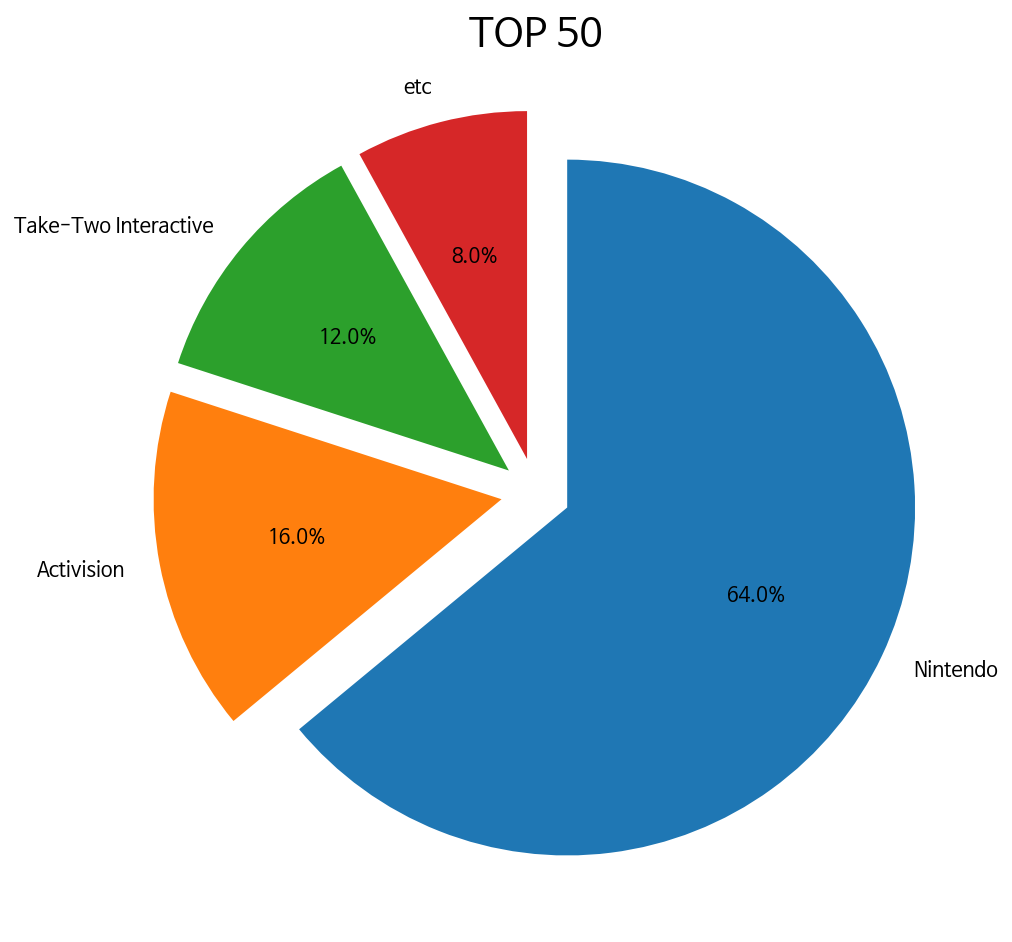

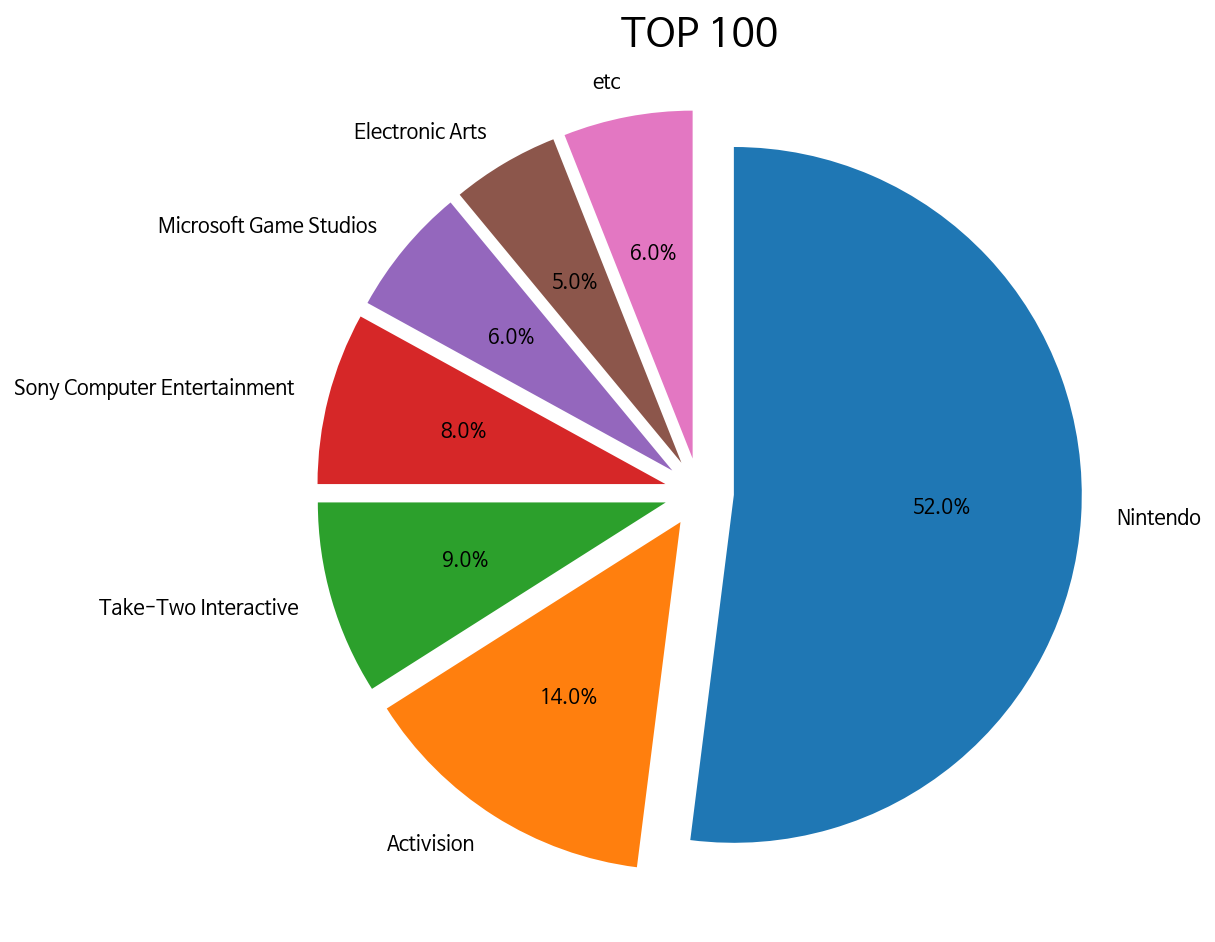

In [ ]:
top10(5,[10, 50, 100],'Publisher')  # (portion, range, genre)

In [ ]:
df_03_top10.to_csv('top10.csv')
df_03_top50.to_csv('top50.csv')
df_03_top100.to_csv('top100.csv')

In [ ]:
df_03_top10

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,2909,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4199,4200,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12579,12580,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,3353,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7829,7830,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1203,1204,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6937,6938,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,3015,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16531,16532,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10488,10489,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


---
> 2010년 이후 데이터 분석

In [ ]:
df_top = df
df_top['Total_Sales'] = round(df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'], 2)
df_top = df_top.fillna('etc')

for i in range(1980,2010): 
    df_top = df_top[df_top['Year'] != i]

In [ ]:
def top10_recent(portion,range,genre): 
    for i in range:
        globals()['df_top{}'.format(i)] = df_top.sort_values(by='Total_Sales', ascending=False).head(i)
        globals()['df_{}'.format(i)] = globals()['df_top{}'.format(i)][genre].value_counts()
        globals()['df_{}'.format(i)] = globals()['df_{}'.format(i)].reset_index()
        globals()['df_{}'.format(i)].loc[len(globals()['df_{}'.format(i)])] = globals()['df_{}'.format(i)].loc[globals()['df_{}'.format(i)][genre] < portion/100*len(globals()['df_top{}'.format(i)]),[genre]].sum(axis=0)
        globals()['df_{}'.format(i)] = globals()['df_{}'.format(i)].fillna('etc')
        globals()['df_{}'.format(i)] = globals()['df_{}'.format(i)][globals()['df_{}'.format(i)][genre] >= portion/100*len(globals()['df_top{}'.format(i)])]
        pie_chart2(i,genre) # 파이차트 함수 호출

In [ ]:
def pie_chart2(i,genre):
    explode = [] 
    for x in range(len(globals()['df_{}'.format(i)])):
        explode.append(0.1)

    plt.rcParams["figure.figsize"] = (12, 8)
    plt.pie(globals()['df_{}'.format(i)][genre], labels =globals()['df_{}'.format(i)]['index'] , autopct='%.1f%%', counterclock=False, startangle=90, explode=explode,shadow=False)
    plt.title('TOP {}'.format(i), fontsize=20);
    plt.show()

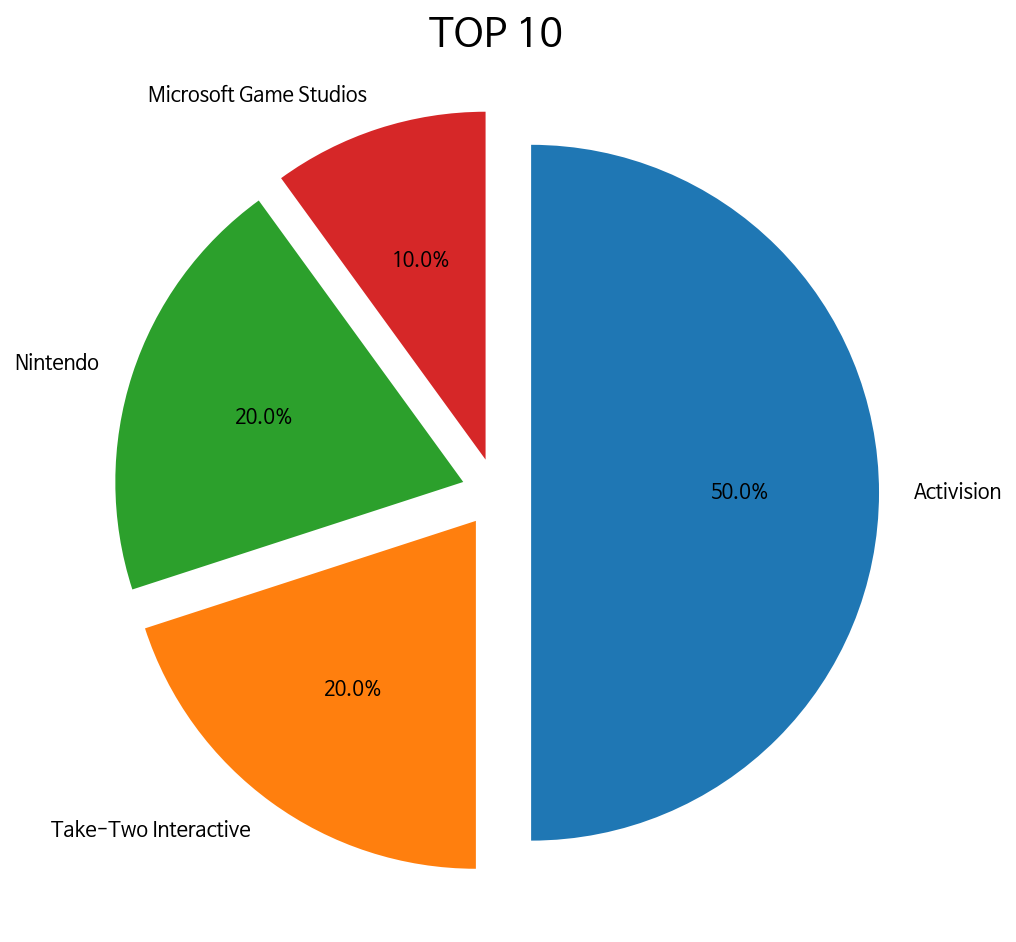

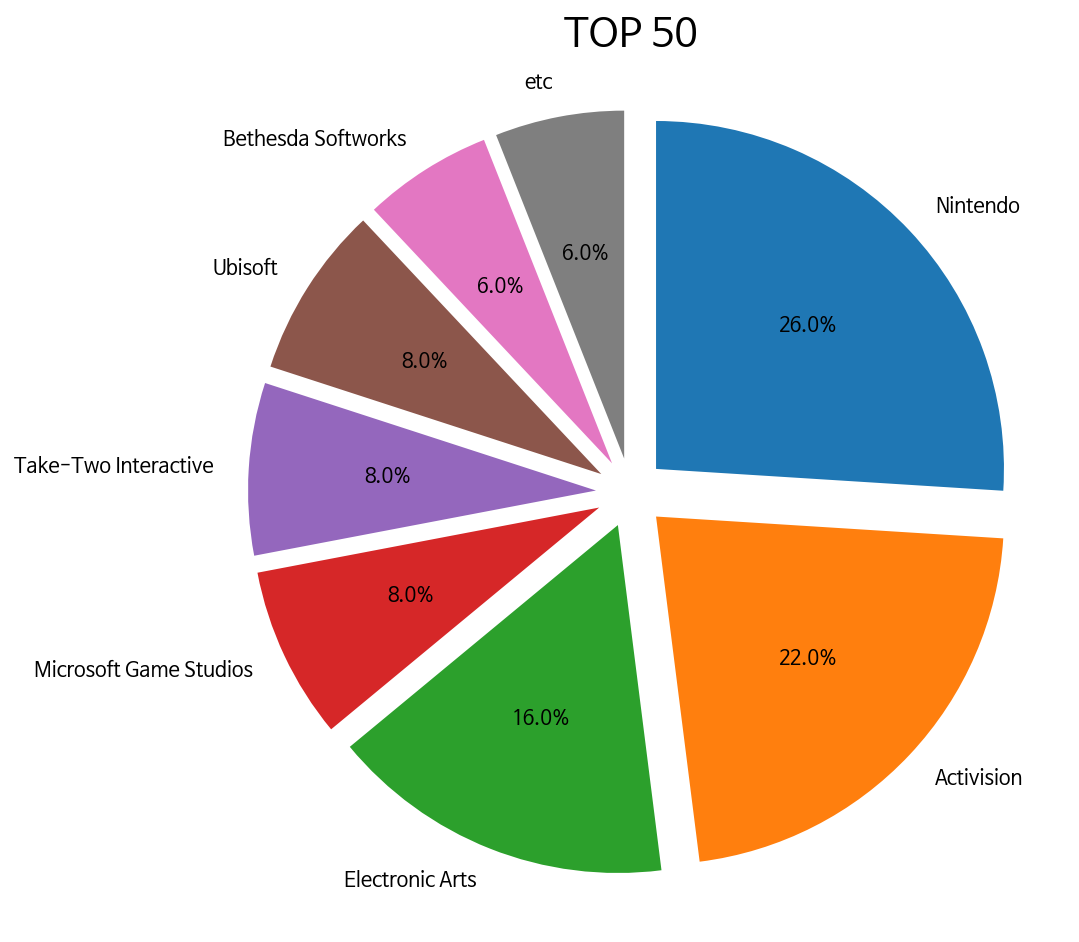

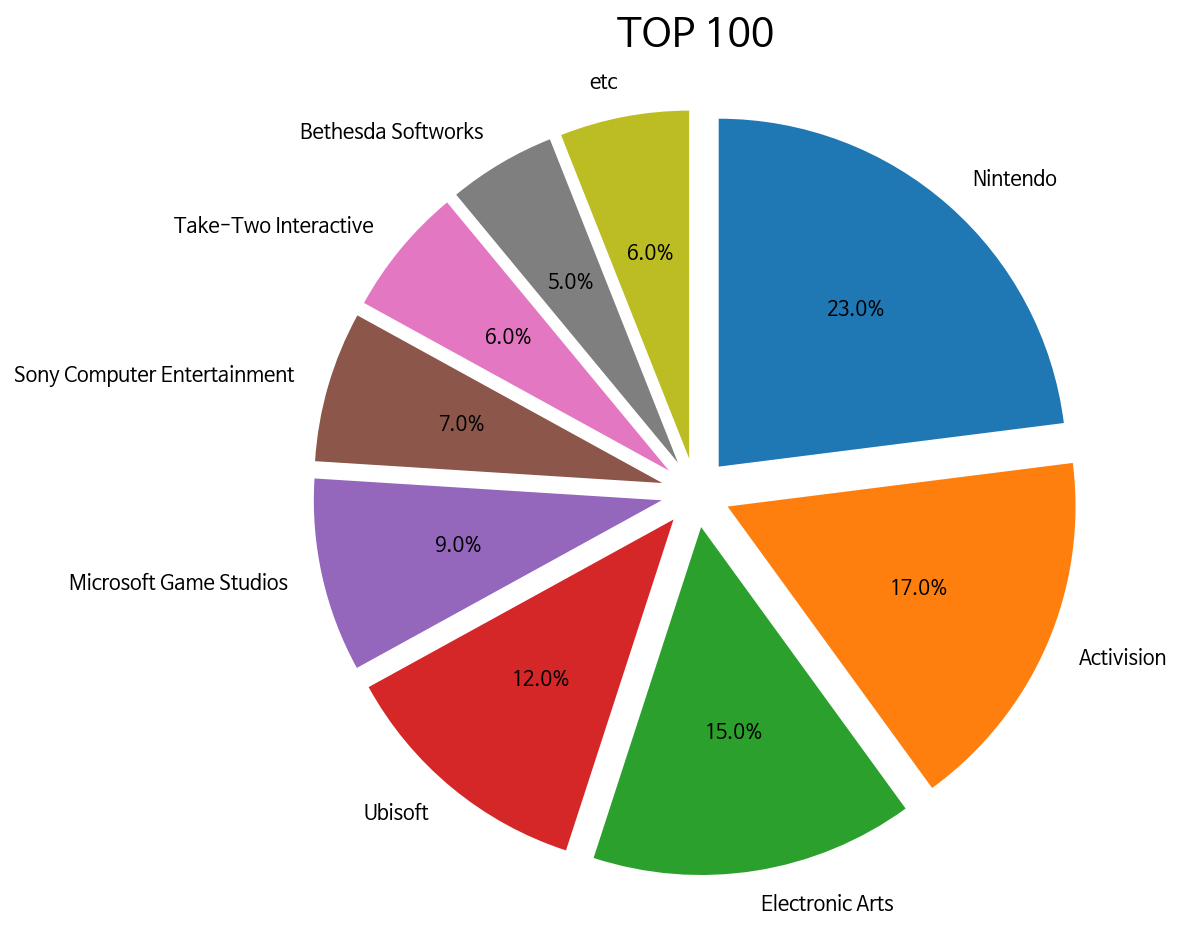

In [ ]:
top10_recent(5,[10, 50, 100],'Publisher')  # (portion, range, genre)

In [ ]:
df_top10.to_csv('top10_recent.csv')
df_top50.to_csv('top50_recent.csv') 
df_top100.to_csv('top100_recent.csv') 

---
> 장르와 플랫폼과의 관계 

In [ ]:
df_04 = df_03
df_04 = df_04.drop(['Unnamed: 0','Name','Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1) 
df_04

,Platform,Genre,Publisher,Total_Sales
0,DS,Action,Destineer,0.04
1,Wii,Action,Namco Bandai Games,0.18
2,PSP,Adventure,Alchemist,0.02
3,DS,Misc,Zoo Games,0.04
4,PS3,Platform,D3Publisher,0.25
...,...,...,...,...
16593,GC,Platform,Vivendi Games,0.20
16594,PSP,Action,Rising Star Games,0.01
16595,PS3,Sports,Take-Two Interactive,0.79
16596,PSV,Action,Tecmo Koei,0.38


In [ ]:
def rel(range, string1, string2): 
    for i in range:
        globals()['df_04_top{}'.format(i)] = df_04.sort_values(by='Total_Sales', ascending=False).head(i)
        obs = pd.crosstab(globals()['df_04_top{}'.format(i)][string1], globals()['df_04_top{}'.format(i)][string2])
        chi2, pv, dof, expected = stats.chi2_contingency(obs, correction=False)
        print('TOP',i,'게임의',string1, '와 ', string2, '의 연관 여부')
        print('- 귀무가설 :', string1,'와',string2,'은 관계가 없다.')
        print('- 대립가설 :', string1,'와',string2,'은 관계가 있다.')
        #print('p-value는 : ',pv)
        if pv >= 0.05:
            print('귀무가설 채택 :', 'p-value 값이', round(pv,2),'으로 0.05 보다 큼')
        else  :
            print('귀무가설 기각 :', 'p-value 값이', round(pv,2),'으로 0.05 보다 작음')

In [ ]:
rel([10],'Genre','Platform')

TOP 10 게임의 Genre 와  Platform 의 연관 여부
- 귀무가설 : Genre 와 Platform 은 관계가 없다.
- 대립가설 : Genre 와 Platform 은 관계가 있다.
귀무가설 채택 : p-value 값이 0.41 으로 0.05 보다 큼


In [ ]:
rel([100],'Genre','Platform')

TOP 100 게임의 Genre 와  Platform 의 연관 여부
- 귀무가설 : Genre 와 Platform 은 관계가 없다.
- 대립가설 : Genre 와 Platform 은 관계가 있다.
귀무가설 기각 : p-value 값이 0.0 으로 0.05 보다 작음


---
> 장르와 퍼블리셔와의 관계

In [ ]:
rel([10],'Genre','Publisher')

TOP 10 게임의 Genre 와  Publisher 의 연관 여부
- 귀무가설 : Genre 와 Publisher 은 관계가 없다.
- 대립가설 : Genre 와 Publisher 은 관계가 있다.
귀무가설 채택 : p-value 값이 1.0 으로 0.05 보다 큼


In [ ]:
rel([100],'Genre','Publisher')

TOP 100 게임의 Genre 와  Publisher 의 연관 여부
- 귀무가설 : Genre 와 Publisher 은 관계가 없다.
- 대립가설 : Genre 와 Publisher 은 관계가 있다.
귀무가설 기각 : p-value 값이 0.0 으로 0.05 보다 작음


---
> 퍼블리셔와 플램폼과의 관계

In [ ]:
rel([10],'Publisher','Platform')

TOP 10 게임의 Publisher 와  Platform 의 연관 여부
- 귀무가설 : Publisher 와 Platform 은 관계가 없다.
- 대립가설 : Publisher 와 Platform 은 관계가 있다.
귀무가설 채택 : p-value 값이 1.0 으로 0.05 보다 큼


In [ ]:
rel([100],'Publisher','Platform')

TOP 100 게임의 Publisher 와  Platform 의 연관 여부
- 귀무가설 : Publisher 와 Platform 은 관계가 없다.
- 대립가설 : Publisher 와 Platform 은 관계가 있다.
귀무가설 기각 : p-value 값이 0.0 으로 0.05 보다 작음


 > 결론 :  인기가 가장 많은 TOP10 게임은 장르, 플랫폼, 퍼블리셔간의 관계가 전혀 없지만, 일반적인 게임에 있어서는 서로의 관계가 매우 밀접하다.

---

### 4. 결론
> 1. 북미, 유럽, 기타 지역은 **슈팅**이 인기 / 일본은 **RPG**가 인기 / 전 지역에 걸처서 **플래폼**이 인기
> 2. 2010년 이후 2012년을 기준으로 **플래폼**은 감소, **슈팅**은 증가
> 3. TOP10(장르) : 슈팅, 액션 / TOP100(장르) : 액션, 슈팅, RPG
> 4. TOP10(플래폼) : 엑스박스, 플레이스테이션 / TOP100(플래폼) : 엑스박스, 플레이스테이션
> 5. TOP10(퍼블리셔) : Activision, Take-Two interactive / TOP100(플래폼) : Nintendo, Activision, EA
> 6. TOP10에서는 장르, 플래폼, 퍼블리셔간 관계없고/ 일반적으로는 관계가 있음

> 